# 🏦 **End-to-End Credit Risk Architecture**
Strategic Optimization of Loan Approvals: A Data Consulting Mission
* **Authors**:  
Khady CISSE,  
Nicola LEVASSEUR,  
Bassem ZAKHER.

* **Context**: Financial Services Consulting | Client: Indian Banking Sector

* **Goal**: Design a robust Data Pipeline & Machine Learning solution to optimize client selection and automate approvals.

## Project Overview (The Business Case)
Our consulting team has been tasked by a major Indian Bank to solve a strategic challenge:: **Improving Client Selection & Operational Efficiency** due to inefficient approval processes.

Currently, the bank lacks historical default data to define "good" borrowers. **Our Solution**: We leverage a **Benchmark Approach** using a mature US dataset (``Loan Confirmation``) to identify reliable borrower profiles, and then apply these insights to automate and standardize the Indian Bank's approval process (``Loan Approval``).

### The "Consultant" Approach: Two Datasets, Two Goals
We utilize two distinct datasets stored in our **Neon Data Warehouse** (PostgreSQL) to address both retrospective analysis and prospective automation.

#### **Phase A: Risk Audit (US Market Analysis)**
* **Dataset**: ``loan_confirmation`` (Historical US Data)
* **Target**: ``loan_paid_back`` (1 = Paid, 0 = Default)
* **Objective**: Analyze **20,000+** historical records to establish a "Gold Standard" for risk by auditing two key dimensions:
    1. **Client Profiling**: Identifying the defining traits of **VIP** (Reliable) vs. **Risky** borrowers (Income, Employment, Credit Score).
    2. **Credit Structure**: Evaluating how loan characteristics (e.g., Term, Interest Rate, Amount) inspired by the mature US market impact the repayment probability.

#### **Phase B: Automation (Indian Market Application)**
* **Dataset**: ``loan_approval`` (Current Indian Data)
* **Target**: ``loan_status`` (1 = Approved, 0 = Rejected)
* **Objective**: Train a **Supervised Machine Learning Model** (Logistic Regression, Random Forest) **automate the approval decision**, allowing the Indian bank to better filter applicants by strictly applying the risk standards validated in Phase A.

### **Technical Architecture & Methodology** 
To deliver a production-ready solution, we implemented a full **ELT (Extract,  Load, Transfor) pipeline**:

1. **Data Engineering (Neon & SQL)**: Secure connection to a cloud Data Warehouse to simulate real-world data ingestion.

2. **Data Preparation (Pandas)**: Advanced cleaning, stripping, and Feature Engineering (Mapping US FICO scores to Indian CIBIL standards).

3. **Visualization (EDA & Power BI)**: In-depth exploration of correlations and creation of business dashboards.

4. **Modeling (Scikit-Learn)**: Comparison of three algorithms to maximize accuracy and recall.

## ***1. Environment Setup & Library Imports***

In this section, we import all the necessary Python libraries to build our end-to-end data pipeline. The stack is organized into four main categories:

Data Manipulation: For handling DataFrames and arrays.

Visualization: To create insightful charts and heatmaps.

Machine Learning: Scikit-Learn modules for preprocessing, modeling, and evaluation.

Data Engineering: Tools to securely connect to our Neon (PostgreSQL) data warehouse.

In [1]:
# Standard Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score

# Configuration to suppress unnecessary warnings for a cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set visual style for plots
sns.set(style="whitegrid")

# Libraries for database connection (Neon Data Warehouse)
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, text

print("="*70)
print("✅ Libraries Loaded Successfully")
print("="*70)

✅ Libraries Loaded Successfully


## ***2. Define Connection Function***

We encapsulate the connection logic within a function. This makes the code modular and allows us to easily re-establish a connection if the session times out or encounters a transaction error (like PendingRollbackError).

In [2]:
# Function to establish a connection to Neon
# Encapsulating this helps avoid transaction errors by ensuring a fresh engine when needed

def neon_conn():
    # Load environment variables
    load_dotenv()                       
    db_url = os.getenv("DATABASE_URL")
    
    # Create and return the database engine
    return create_engine(db_url)

# Initialize the connection
engine = neon_conn() 

print("=" * 70 )
print("✅ Connection Engine Created")
print("=" * 70 )

✅ Connection Engine Created


### Test Database Connection
Before proceeding with data extraction, we execute a simple SQL query (SELECT version();) to verify that the connection to the Neon server is active and stable.

In [3]:
# Test the connection using the created engine
# We use a context manager ('with') to ensure the connection closes automatically after the query

with engine.connect() as conn:
    # 'text()' is required by SQLAlchemy for raw SQL strings
    result = conn.execute(text("SELECT version();"))

    # Fetch and print the server version to confirm success
    print("=" * 70 )
    print(result.fetchone())
    print("=" * 70 )

('PostgreSQL 17.7 (bdc8956) on aarch64-unknown-linux-gnu, compiled by gcc (Debian 12.2.0-14+deb12u1) 12.2.0, 64-bit',)


## ***3. ELT Process (Extract, Load, Transform)***

### 3.1 Ingestion: Loan Approval Dataset
First, we load the `loan_approval_dataset.csv` from our local environment into a Pandas DataFrame.
Code :

In [4]:
# Load the local CSV file into a DataFrame
df_approval = pd.read_csv("loan_approval_dataset.csv")

# Display the first few rows to verify the load
df_approval.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


### 3.2 Pushing Loan Approval (Neon)
☁️ Push to Data Warehouse (Raw Layer)

In [5]:
# We upload the raw data to Neon. We use `if_exists='replace'` to ensure we always start with a fresh copy of the raw data in our database.

# Re-establish the connection to prevent transaction timeouts
engine = neon_conn()

# Write the DataFrame to the Neon database
df_approval.to_sql(
    name="loan_approval_raw",   # Table name in Neon (Bronze Layer)
    con=engine,                 # Database connection engine
    if_exists="replace",        # Overwrite table if it exists
    index=False                 # Do not save the DataFrame index as a column
)

print("=" * 70)
print("✅ 'loan_approval_raw' successfully uploaded to Neon.")
print("=" * 70)

✅ 'loan_approval_raw' successfully uploaded to Neon.


### 3.3 Ingestion: Loan Confirmation Dataset
Next, we handle the second dataset, `loan_dataset_20000.csv`, which contains confirmation details.

In [6]:
# Load the second CSV file
df_confirmation = pd.read_csv("loan_dataset_20000.csv")

# Display the first few rows
df_confirmation.head()

,age,gender,marital_status,education_level,annual_income,monthly_income,employment_status,debt_to_income_ratio,credit_score,loan_amount,...,loan_term,installment,grade_subgrade,num_of_open_accounts,total_credit_limit,current_balance,delinquency_history,public_records,num_of_delinquencies,loan_paid_back
0,59,Male,Married,Master's,24240.19,2020.02,Employed,0.074,743,17173.72,...,36,581.88,B5,7,40833.47,24302.07,1,0,1,1
1,72,Female,Married,Bachelor's,20172.98,1681.08,Employed,0.219,531,22663.89,...,60,573.17,F1,5,27968.01,10803.01,1,0,3,1
2,49,Female,Single,High School,26181.80,2181.82,Employed,0.234,779,3631.36,...,60,76.32,B4,2,15502.25,4505.44,0,0,0,1
3,35,Female,Single,High School,11873.84,989.49,Employed,0.264,809,14939.23,...,36,468.07,A5,7,18157.79,5525.63,4,0,5,1
4,63,Other,Single,Other,25326.44,2110.54,Employed,0.260,663,16551.71,...,60,395.50,D5,1,17467.56,3593.91,2,0,2,1


### 3.4 Pushing Loan Confirmation (Neon) 
☁️ Push to Data Warehouse (Raw Layer)
Similarly, we upload the confirmation dataset to the raw layer in Neon.

In [7]:
# Refresh connection
engine = neon_conn()

# Write the second DataFrame to Neon
df_confirmation.to_sql(
    name="loan_confirmation_raw",
    con=engine,
    if_exists="replace",
    index=False
)

print("=" * 70)
print("'loan_confirmation_raw' successfully uploaded to Neon.")
print("=" * 70)

'loan_confirmation_raw' successfully uploaded to Neon.


## ***4. Extract & Audit: Loan Confirmation (US dataset)***

Now, we query the loan_confirmation_raw table from Neon to bring it back into our Python environment for processing. This serves as our Working Copy.

In [8]:
# Define the SQL query to fetch the raw data
sql_query_confirmation = """
SELECT * FROM public.loan_confirmation_raw;
"""

### 🔍 Data Loading & Statistical Summary
We execute the query and generate a statistical summary (describe) to audit the data quality (missing values, outliers, or formatting issues) before cleaning.

In [9]:
# 1. Reset Connection (Transaction Safety)
# Update the 'engine' variable with a fresh connection
engine = neon_conn()

# 2. Extract Data
print("=" * 70)
print("⬇️ Downloading data from Neon...")
print("=" * 35)

# We use 'loan_confirmation' as our working variable (it is not clean yet)
loan_confirmation = pd.read_sql(sql_query_confirmation, engine)

# 3. Verification
print(f" DataFrame loan_confirmation Loaded. Shape: {loan_confirmation.shape}")
print("=" * 70)

# 4. Statistical Summary (Audit)
# include='all' forces analysis of both Numeric and Text columns
loan_confirmation.describe(include="all")

⬇️ Downloading data from Neon...
 DataFrame loan_confirmation Loaded. Shape: (20000, 22)


,age,gender,marital_status,education_level,annual_income,monthly_income,employment_status,debt_to_income_ratio,credit_score,loan_amount,...,loan_term,installment,grade_subgrade,num_of_open_accounts,total_credit_limit,current_balance,delinquency_history,public_records,num_of_delinquencies,loan_paid_back
count,20000.000000,20000,20000,20000,20000.000000,20000.000000,20000,20000.000000,20000.00000,20000.000000,...,20000.00000,20000.000000,20000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
unique,NaN,3,4,5,NaN,NaN,5,NaN,NaN,NaN,...,NaN,NaN,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Female,Single,Bachelor's,NaN,NaN,Employed,NaN,NaN,NaN,...,NaN,NaN,C3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,10034,9031,8045,NaN,NaN,13007,NaN,NaN,NaN,...,NaN,NaN,1514,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,48.027000,NaN,NaN,NaN,43549.637765,3629.136466,NaN,0.177019,679.25695,15129.300909,...,43.22280,455.625794,NaN,5.011800,48649.824769,24333.394631,1.990150,0.061800,2.489150,0.799900
std,15.829352,NaN,NaN,NaN,28668.579671,2389.048326,NaN,0.105059,69.63858,8605.405513,...,11.00838,274.622125,NaN,2.244529,32423.378128,22313.845395,1.474945,0.285105,1.631384,0.400085
min,21.000000,NaN,NaN,NaN,6000.000000,500.000000,NaN,0.010000,373.00000,500.000000,...,36.00000,9.430000,NaN,0.000000,6157.800000,496.350000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,NaN,NaN,NaN,24260.752500,2021.730000,NaN,0.096000,632.00000,8852.695000,...,36.00000,253.910000,NaN,3.000000,27180.492500,9592.572500,1.000000,0.000000,1.000000,1.000000
50%,48.000000,NaN,NaN,NaN,36585.260000,3048.770000,NaN,0.160000,680.00000,14946.170000,...,36.00000,435.595000,NaN,5.000000,40241.615000,18334.555000,2.000000,0.000000,2.000000,1.000000
75%,62.000000,NaN,NaN,NaN,54677.917500,4556.495000,NaN,0.241000,727.00000,20998.867500,...,60.00000,633.595000,NaN,6.000000,60361.257500,31743.327500,3.000000,0.000000,3.000000,1.000000


### Data Quality Audit (Data Quality Check)

This block manually constructs a **Dynamic Data Dictionary** to audit the dataset across six key dimensions:

1.  **Variable (Structure)**: Lists all available columns.
2.  **Python Type**: Verifies data types (`int`, `float`, `object`) to spot potential parsing errors (e.g., numeric values stored as text).
3.  **Unique Values**: Displays the actual content of unique entries.
4.  **Unique Count (Cardinality)**: Calculates the number of distinct values per column, essential for distinguishing between categorical and continuous variables.
5.  **Missing Values (Count)**: Provides the exact volume of null values.
6.  **Missing Values (%)**: Calculates the **percentage** of missing data, which is the decisive factor for choosing a cleaning strategy (Drop rows vs. Impute values).

In [10]:
# Create a custom Data Quality Summary DataFrame for Loan Confirmation
summary_confirmation = pd.DataFrame({
    # 1. Column Name
    "Variable": loan_confirmation.columns,
    
    # 2. Data Type check
    "Python Type": loan_confirmation.dtypes.values,
    
    # 3. List of unique values (to spot " Approved" vs "Approved")
    "Unique Values": [loan_confirmation[col].unique() for col in loan_confirmation.columns],
    
    # 4. Count of unique values
    "Unique Count": [loan_confirmation[col].nunique() for col in loan_confirmation.columns],
    
    # 5. Counting Missing Values (Null/NaN)
    "Missing Values": [loan_confirmation[col].isna().sum() for col in loan_confirmation.columns], 
    
    # 6. Percentage of missing values
    "Missing %": [loan_confirmation[col].isna().sum() / len(loan_confirmation) * 100 for col in loan_confirmation.columns]
})

# Display the summary
summary_confirmation

,Variable,Python Type,Unique Values,Unique Count,Missing Values,Missing %
0,age,int64,"[59, 72, 49, 35, 63, 28, 41, 39, 43, 31, 44, 7...",55,0,0.0
1,gender,object,"[Male, Female, Other]",3,0,0.0
2,marital_status,object,"[Married, Single, Divorced, Widowed]",4,0,0.0
3,education_level,object,"[Master's, Bachelor's, High School, Other, PhD]",5,0,0.0
4,annual_income,float64,"[24240.19, 20172.98, 26181.8, 11873.84, 25326....",19947,0,0.0
5,monthly_income,float64,"[2020.02, 1681.08, 2181.82, 989.49, 2110.54, 4...",19636,0,0.0
6,employment_status,object,"[Employed, Unemployed, Self-employed, Student,...",5,0,0.0
7,debt_to_income_ratio,float64,"[0.074, 0.219, 0.234, 0.264, 0.26, 0.081, 0.16...",555,0,0.0
8,credit_score,int64,"[743, 531, 779, 809, 663, 774, 742, 810, 724, ...",399,0,0.0
9,loan_amount,float64,"[17173.72, 22663.89, 3631.36, 14939.23, 16551....",18819,0,0.0


## ***5. Extract & Audit: Loan Approval (Indian dataset)***

We repeat the extraction process for the `loan_approval` dataset (the one containing the target variable).

In [11]:
# Define the SQL query to fetch the raw data
sql_loan_approval = """
SELECT * FROM public.loan_approval_raw;
"""

### 🔍 Data Loading & Statistical Summary
We download the data and run a statistical overview.

In [12]:
# 1. Reset Connection (Transaction Safety)
engine = neon_conn()

# 2. Extract Data
print("=" * 70)
print("⬇️ Downloading data from Neon...")
print("=" * 35)

# We use 'loan_approval' as our working variable
loan_approval = pd.read_sql(sql_loan_approval, engine)

# 3. Verification
print(f"✅ DataFrame loan_approval Loaded. Shape: {loan_approval.shape}")
print("=" * 70)

# 4. Statistical Summary (Audit)
loan_approval.describe(include="all")

⬇️ Downloading data from Neon...
✅ DataFrame loan_approval Loaded. Shape: (4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,4269.000000,4269.000000,4269,4269,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4269
unique,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,Graduate,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Approved
freq,NaN,NaN,2144,2150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2656
mean,2135.000000,2.498712,NaN,NaN,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06,NaN
std,1232.498479,1.695910,NaN,NaN,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06,NaN
min,1.000000,0.000000,NaN,NaN,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00,NaN
25%,1068.000000,1.000000,NaN,NaN,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06,NaN
50%,2135.000000,3.000000,NaN,NaN,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06,NaN
75%,3202.000000,4.000000,NaN,NaN,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06,NaN


### 🕵️‍♂️ Data Quality Audit
We apply the same Data Quality check to the approval dataset to identify high-cardinality features and missing values.

In [13]:
# Create a custom Data Quality Summary DataFrame for Loan Approval
summary_approval = pd.DataFrame({
    "Variable": loan_approval.columns,
    "Python Type": loan_approval.dtypes.values,
    "Unique Values": [loan_approval[col].unique() for col in loan_approval.columns],
    "Unique Count": [loan_approval[col].nunique() for col in loan_approval.columns],
    "Missing Values": [loan_approval[col].isna().sum() for col in loan_approval.columns], 
    "Missing %": [loan_approval[col].isna().sum() / len(loan_approval) * 100 for col in loan_approval.columns]
})

# Display the summary
summary_approval

,Variable,Python Type,Unique Values,Unique Count,Missing Values,Missing %
0,loan_id,int64,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",4269,0,0.0
1,no_of_dependents,int64,"[2, 0, 3, 5, 4, 1]",6,0,0.0
2,education,object,"[ Graduate, Not Graduate]",2,0,0.0
3,self_employed,object,"[ No, Yes]",2,0,0.0
4,income_annum,int64,"[9600000, 4100000, 9100000, 8200000, 9800000, ...",98,0,0.0
5,loan_amount,int64,"[29900000, 12200000, 29700000, 30700000, 24200...",378,0,0.0
6,loan_term,int64,"[12, 8, 20, 10, 4, 2, 18, 16, 14, 6]",10,0,0.0
7,cibil_score,int64,"[778, 417, 506, 467, 382, 319, 678, 782, 388, ...",601,0,0.0
8,residential_assets_value,int64,"[2400000, 2700000, 7100000, 18200000, 12400000...",278,0,0.0
9,commercial_assets_value,int64,"[17600000, 2200000, 4500000, 3300000, 8200000,...",188,0,0.0


## 📊 ***6. EDA: Loan Confirmation (raw dataset)***

### 6.1 Distribution of Numeric Features
We start by visualizing the distribution of all numerical variables. This allows us to:

* Identify Skewness: Are the data normally distributed or skewed to the left/right?
* Detect Outliers: Are there detached bars at the extremes?
* Understand Scales: What are the ranges of values (e.g., Income vs. Age)?

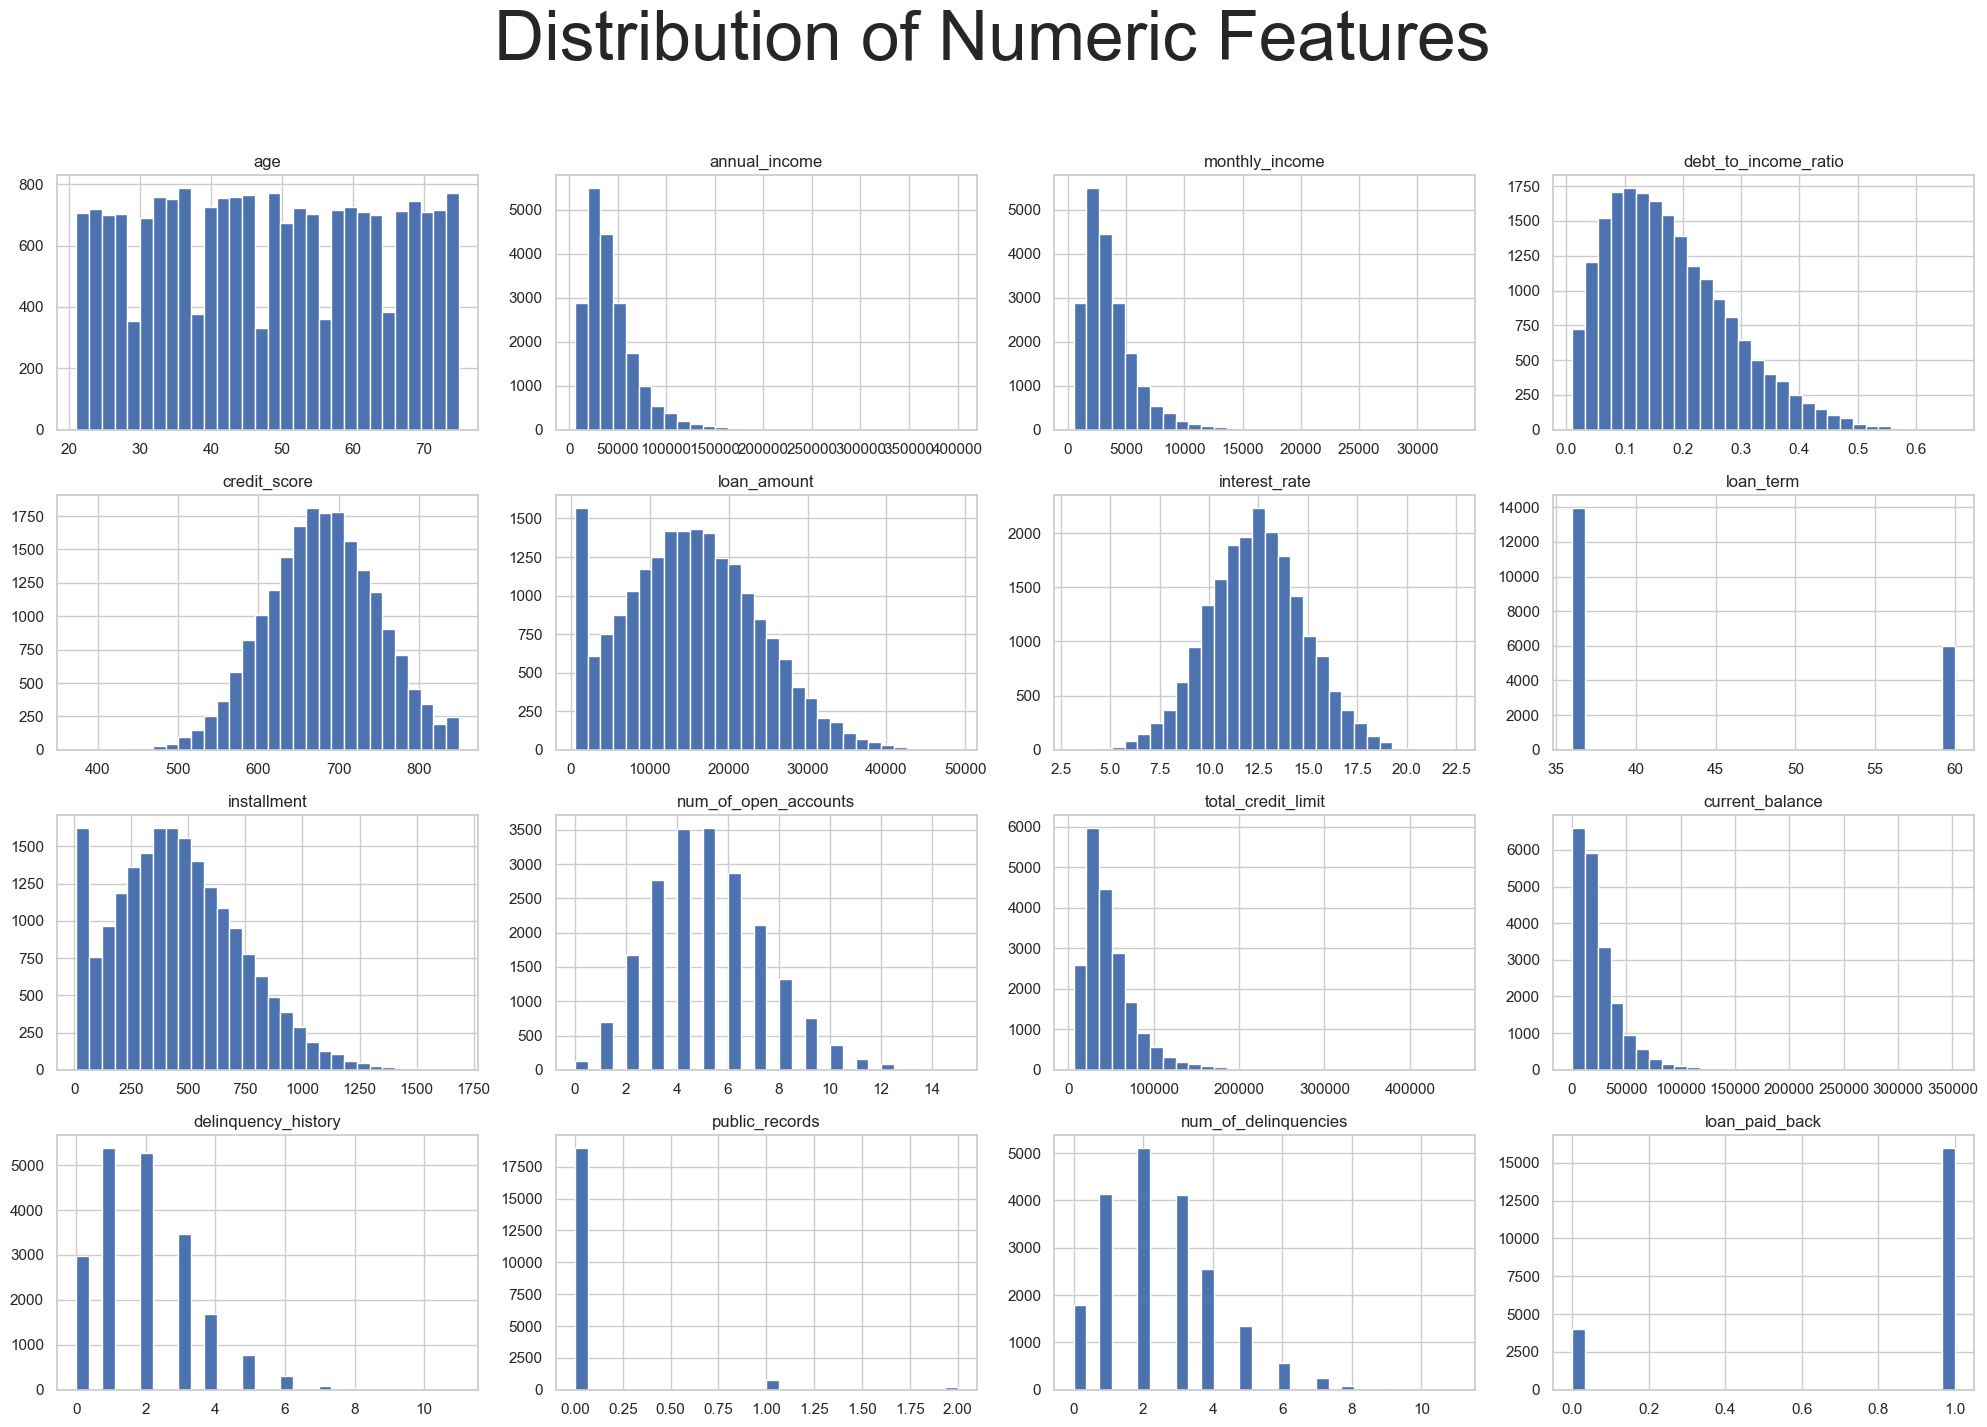

In [14]:
# Visualize distributions of all numeric features
# 'bins=30' provides enough granularity to observe the shape of the distribution
# 'layout=(5, 5)' arranges the subplots in a grid (adjust based on column count)
loan_confirmation.hist(bins=30, figsize=(20, 15), layout=(4, 4)) 

plt.suptitle('Distribution of Numeric Features', fontsize=50)

# Adjusts subplot params so that subplots are formatted nicely and don't overlap
# rect=[...] leaves space at the top for the suptitle
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

### 6.2 Target Variable Analysis
We examine the balance of our target variable `loan_paid_back`.
* **Imbalance Check:** Is the dataset balanced (50/50) or imbalanced? Machine Learning models often struggle with highly imbalanced classes (e.g., 90% vs 10%).

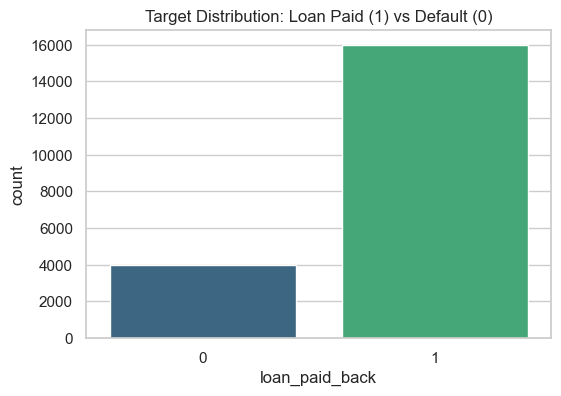

Target Class Proportions:
loan_paid_back
1    0.7999
0    0.2001
Name: proportion, dtype: float64


In [15]:
# Visualize the target variable (Loan Status)
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_paid_back', data=loan_confirmation, palette='viridis')
plt.title('Target Distribution: Loan Paid (1) vs Default (0)')
plt.show()

# Print specific percentage to quantify imbalance
print("=" * 70)
print("Target Class Proportions:")
print("=" * 35)
print(loan_confirmation['loan_paid_back'].value_counts(normalize=True))
print("=" * 70)

### 6.3 Correlation Analysis
We generate a heatmap to detect relationships between numerical variables.
* **Collinearity:** We look for red squares (high positive correlation) between independent variables (e.g. annual_income vs. monthly_income). If two features are too correlated, we might need to drop one to avoid multicollinearity.

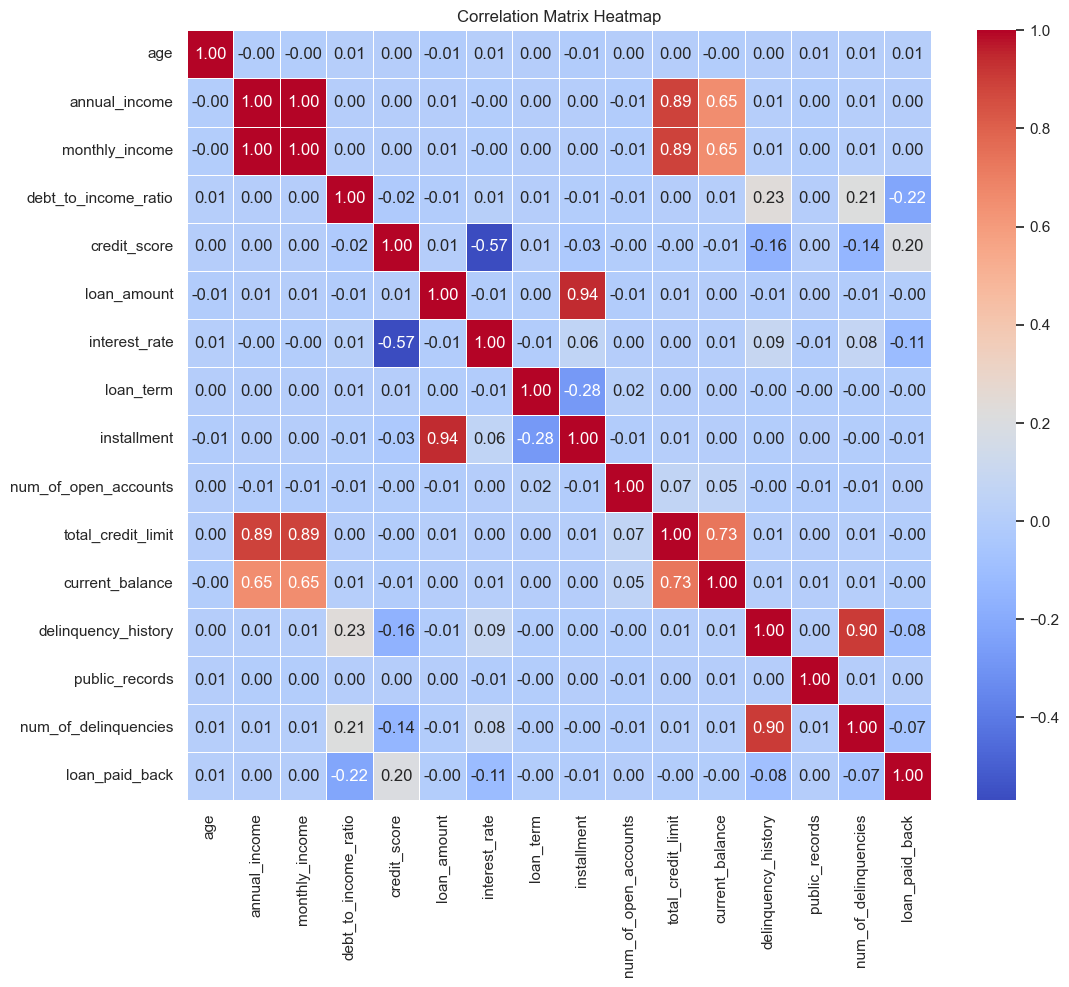

In [16]:
# Correlation Matrix
plt.figure(figsize=(12, 10))

# Select only numeric columns to avoid errors with text data
numeric_df = loan_confirmation.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

# Draw the heatmap
# annot=True adds the numbers, fmt=".2f" rounds to 2 decimals
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

### 6.4 Categorical Features Analysis
We analyze how social factors (Employment, Marital Status) impact the repayment rate.
* **Methodology:** For Employment and Education, we use a Bar Plot which calculates the **mean** of the target. Since our target is 0/1, the mean represents the **Probability of Repayment**.

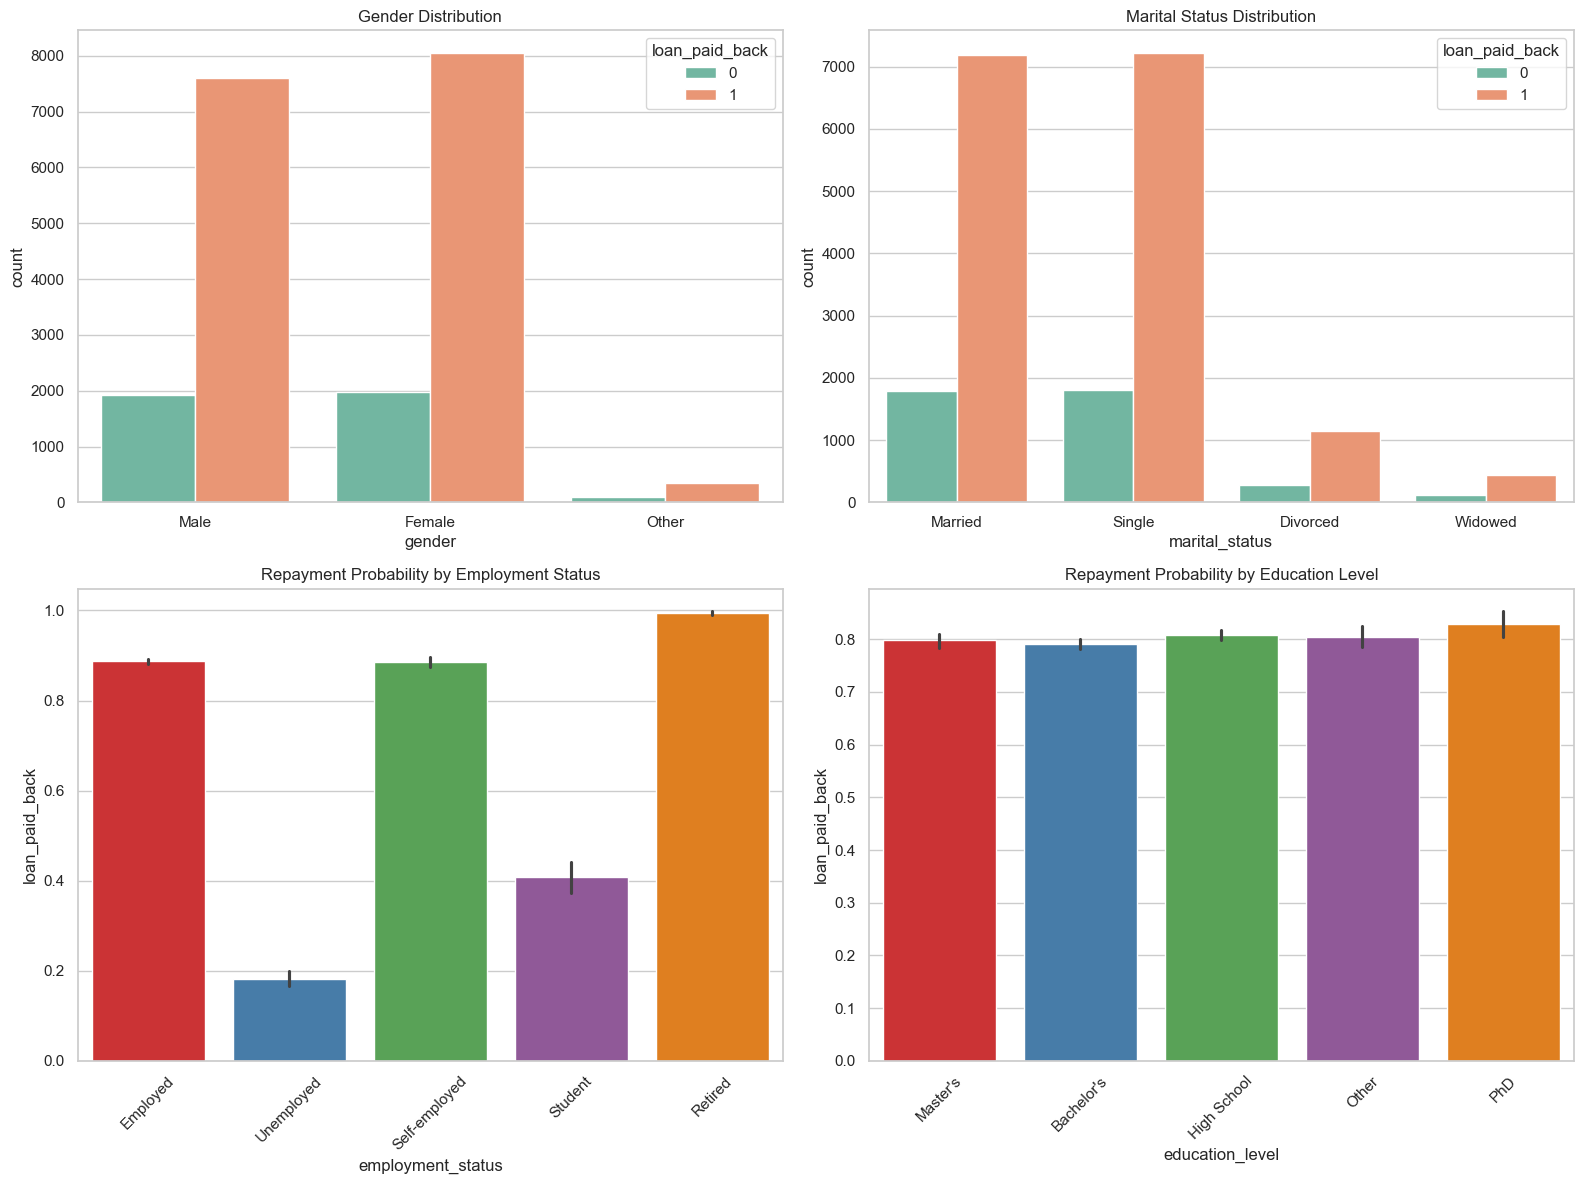

In [17]:
# Set up a grid of plots for categorical features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Gender vs Loan Status (Count)
sns.countplot(ax=axes[0, 0], x='gender', hue='loan_paid_back', data=loan_confirmation, palette='Set2')
axes[0, 0].set_title('Gender Distribution')

# 2. Marital Status vs Loan Status (Count)
sns.countplot(ax=axes[0, 1], x='marital_status', hue='loan_paid_back', data=loan_confirmation, palette='Set2')
axes[0, 1].set_title('Marital Status Distribution')

# 3. Employment Status vs Repayment Rate (Probability)
# The y-axis represents the % of loans paid back
sns.barplot(ax=axes[1, 0], x='employment_status', y='loan_paid_back', data=loan_confirmation, palette='Set1')
axes[1, 0].set_title('Repayment Probability by Employment Status')
axes[1, 0].tick_params(axis='x', rotation=45) # Rotate labels for readability

# 4. Education Level vs Repayment Rate (Probability)
sns.barplot(ax=axes[1, 1], x='education_level', y='loan_paid_back', data=loan_confirmation, palette='Set1')
axes[1, 1].set_title('Repayment Probability by Education Level')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 📊 ***7. EDA: Loan Approval (raw dataset)***

### 7.1 Distribution of Numeric Features
We visualize the distributions to understand the spread of data in the raw approval dataset. This helps us spot potential outliers in income or loan amounts.

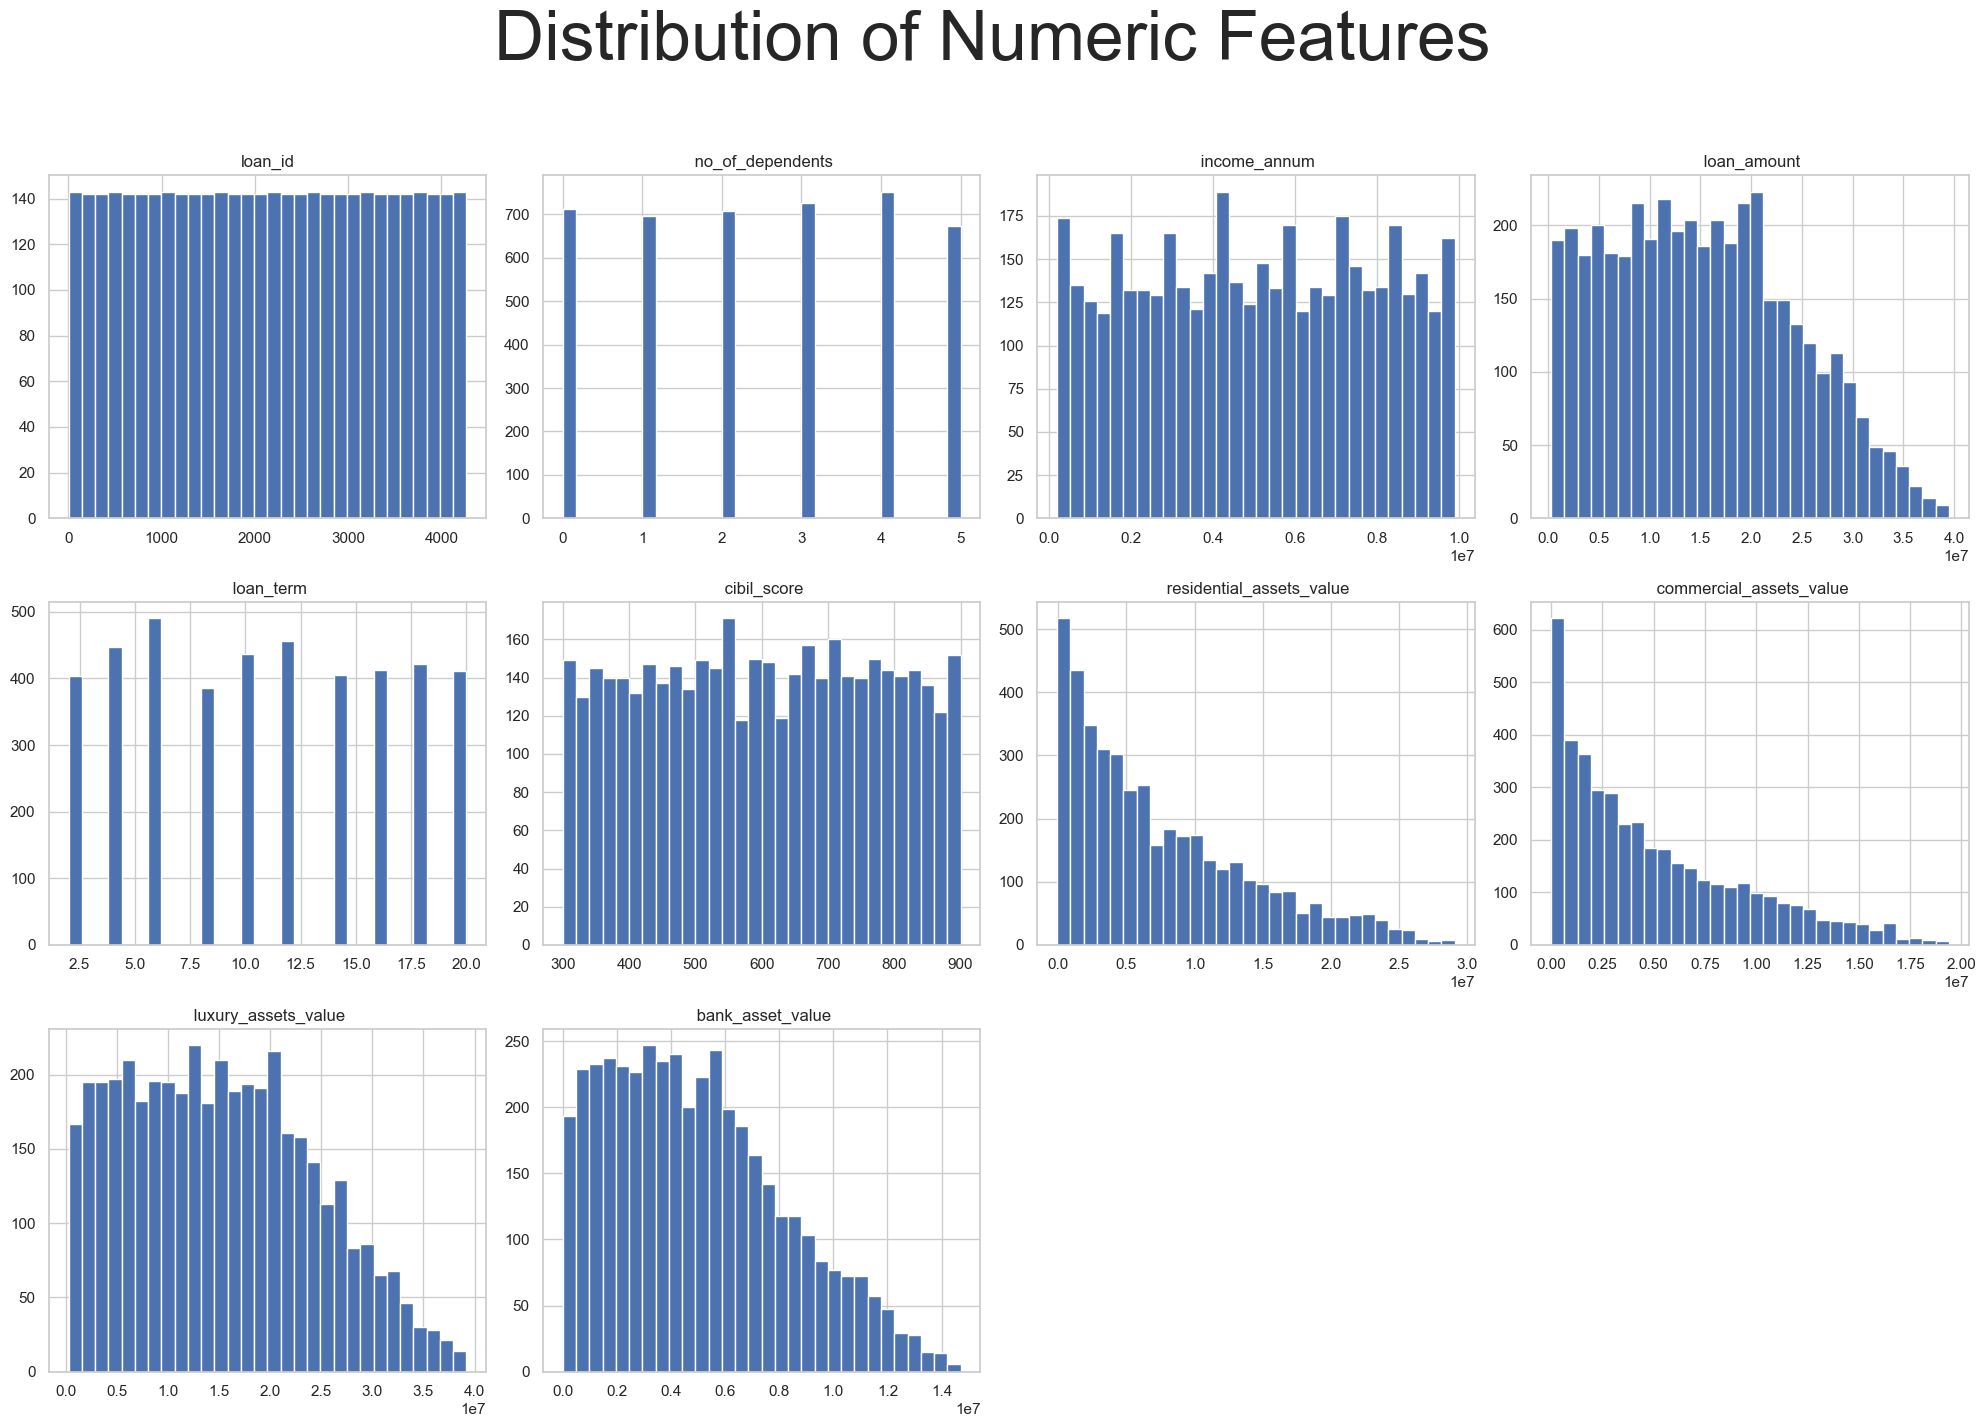

In [18]:
# Visualize distributions of all numeric features
# 'bins=30' helps identify skewness and outliers effectively
loan_approval.hist(bins=30, figsize=(20, 15), layout=(3, 4)) 

plt.suptitle('Distribution of Numeric Features', fontsize=50)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the title
plt.show()

### 7.2 Target Variable Analysis
We examine the loan_status column. Since this is our target for classification, knowing the baseline approval rate is crucial for evaluating model performance later.

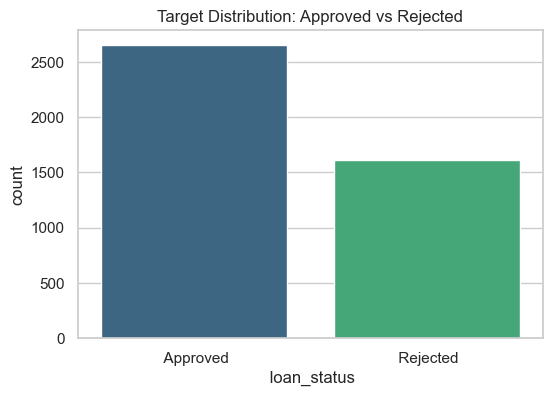

Target Class Proportions:
 loan_status
Approved    0.62216
Rejected    0.37784
Name: proportion, dtype: float64


In [19]:
# Visualize the target variable (Loan Status)
plt.figure(figsize=(6, 4))

# Note: We use ' loan_status' (with space) because we are analyzing the raw dataset
sns.countplot(x=' loan_status', data=loan_approval, palette='viridis')
plt.title('Target Distribution: Approved vs Rejected')
plt.show()

# Print specific percentage of Approved vs Rejected
print("=" * 70)
print("Target Class Proportions:")
print("=" * 35)
print(loan_approval[' loan_status'].value_counts(normalize=True))
print("=" * 70)

### 7.3 Categorical Features Analysis
We analyze the relationship between categorical profile data (Education, Self-Employment) and the loan decision.

Value Labels: We add labels to the bars to see the exact counts for each category.

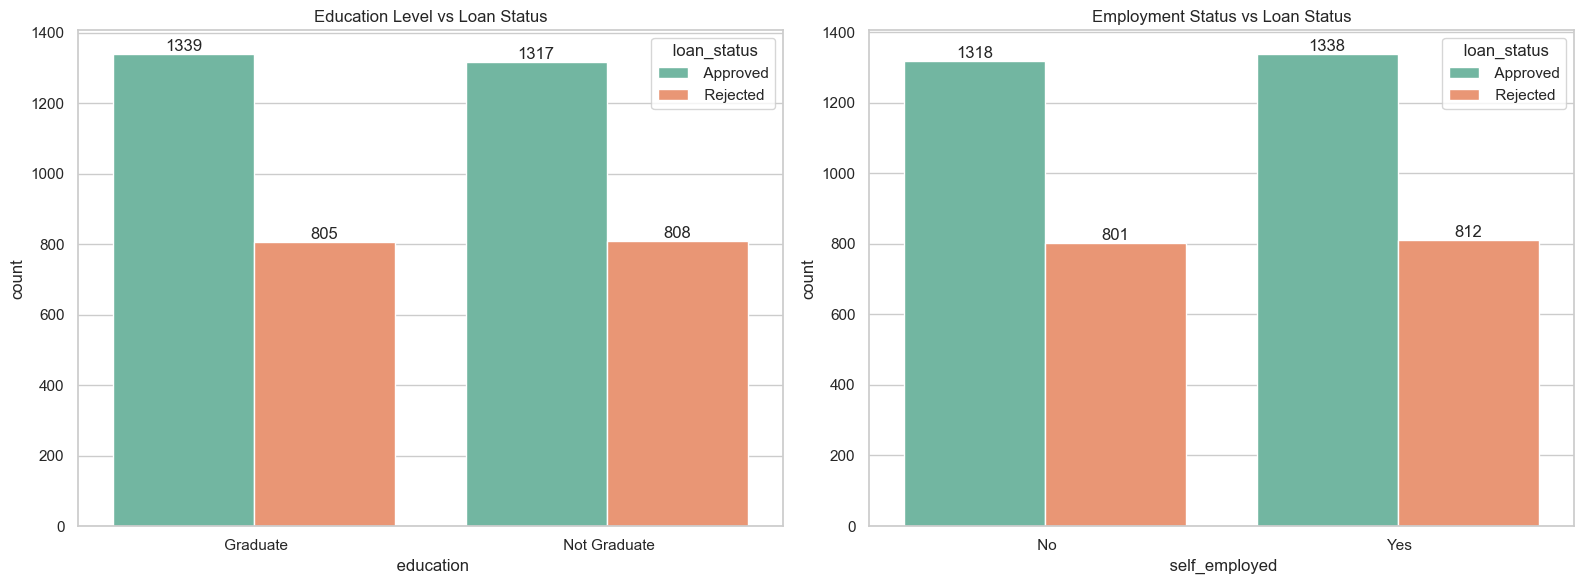

In [20]:
# Set up a grid of plots for categorical features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Education level vs Loan Status
sns.countplot(ax=axes[0], x=' education', hue=' loan_status', data=loan_approval, palette='Set2')
axes[0].set_title('Education Level vs Loan Status')

# Displaying the values on top of the bars
for i in axes[0].containers:
    axes[0].bar_label(i)

# 2. Self_employed vs Loan Status
sns.countplot(ax=axes[1], x=" self_employed", hue=' loan_status', data=loan_approval, palette='Set2')
axes[1].set_title('Employment Status vs Loan Status')

# Displaying the values on top of the bars
for i in axes[1].containers:
    axes[1].bar_label(i)

plt.tight_layout()
plt.show()

### 7.4 Correlation Analysis
Finally, we check for correlations in the raw numerical data.

Note: We explicitly remove loan_id from this analysis as it is just an identifier and has no statistical relationship with the other variables.

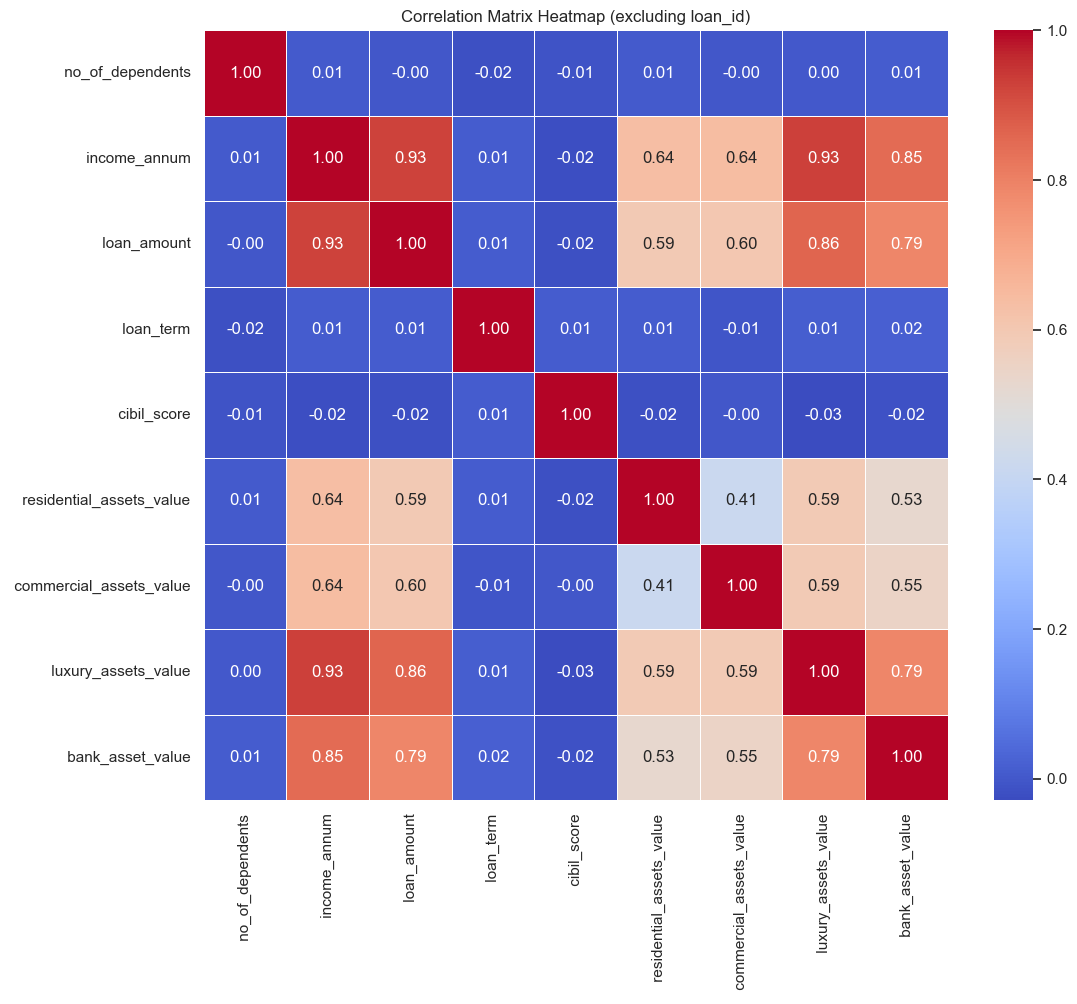

In [21]:
# Correlation Matrix
plt.figure(figsize=(12, 10))

# 1. Select numeric columns
numeric_df = loan_approval.select_dtypes(include=[np.number])

# 2. Exclude 'loan_id' (which is numeric but meaningless for correlation)
# We try dropping both ' loan_id' (raw name with space) and 'loan_id' (clean name) just to be safe
numeric_df = numeric_df.drop(columns=[' loan_id', 'loan_id'], errors='ignore')

# 3. Calculate Correlation
correlation_matrix = numeric_df.corr()

# 4. Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap (excluding loan_id)')
plt.show()

## ***8. Data Cleaning & Feature Engineering: Loan Confirmation***

#### In this section, we process the loan_confirmation dataset to create a clean, business-ready version (loan_confirmation_clean). We perform data standardization, remove redundant features, and engineer new variables for better analysis.

##### 📋 Key Steps Performed:
**1. Whitespace Removal:**
* We strip all leading and trailing spaces from column names. The strip is limited for the object columns to avoid any alteration of numeric variables.
* We apply the same cleaning to all string (object) values in the dataframe to prevent matching errors.

**2. Credit Score Categorization (Feature Engineering):**
* We map the raw credit_score to simplified categories based on FICO standards:
* Risky: Score < 580
* Excellent: Score ≥ 740
* Standard: Everything in between.

**3. Dimensionality Reduction:**
* We drop columns identified as redundant or having high collinearity  
(``education_level``, ``monthly_income``, ``installment``, ``num_of_delinquencies``) to streamline the dataset.

**4. Loan Term Conversion:**
* We create loan_term_years by dividing the term in months by 12.

**5. Grade Extraction:**
* We simplify the granular grade_subgrade (e.g., "A1", "B2") to a high-level borrower_grade (e.g., "A", "B").

**6. Demographic Segmentation:**
* We bin age into 5 distinct groups: <25, 25-34, 35-49, 50-59, and 60+.

**7. Risk Rating (DTI):**
* We categorize the debt_to_income_ratio into 4 clear risk levels:
    * Excellent: < 20%
    * Standard: 20% - 35%
    * Risky: 36% - 43%
    * Danger: > 43%

**8. Loan Amount Segmentation:**
* We segment the loan_amount into business-friendly categories:
    * <9k
    * 9-15k
    * 15-21k
    * 21k+  

**9. Mapping the loan_paid_back_term column**
* Replacing the 1 for paid, and 0 for default

In [22]:
# --- STEP 0: INITIALIZATION ---
# We create a new variable 'loan_confirmation_clean' to preserve the working copy
loan_confirmation_clean = loan_confirmation.copy()

# Verification
print("=" * 70)
print("0. Working copy created successfully.")
print(f"   Initial Shape: {loan_confirmation_clean.shape}")
print("=" * 70)

0. Working copy created successfully.
   Initial Shape: (20000, 22)


In [23]:
loan_confirmation_clean.columns

Index(['age', 'gender', 'marital_status', 'education_level', 'annual_income',
       'monthly_income', 'employment_status', 'debt_to_income_ratio',
       'credit_score', 'loan_amount', 'loan_purpose', 'interest_rate',
       'loan_term', 'installment', 'grade_subgrade', 'num_of_open_accounts',
       'total_credit_limit', 'current_balance', 'delinquency_history',
       'public_records', 'num_of_delinquencies', 'loan_paid_back'],
      dtype='object')

#### The Cleaning Pipeline

In [24]:
# Check initial column names (before cleaning)
print("=" * 70)
print("Initial Columns:")
print(loan_confirmation.columns)
print("=" * 35)

# --- STEP 1: CLEANING SPACES (STRIP) ---

# 1. Remove spaces from column names
loan_confirmation_clean.columns = loan_confirmation_clean.columns.str.strip()

# 2. Remove spaces from all string values in the DataFrame
# Identify columns with type 'object' (text)
str_cols = loan_confirmation_clean.select_dtypes(include=['object']).columns

# Apply the .strip() function to each string column
for col in str_cols:
    loan_confirmation_clean[col] = loan_confirmation_clean[col].str.strip()

# Verification
print("1. Spaces removed from columns and values.")
print("=" * 35)

# --- STEP 2: FEATURE ENGINEERING (Credit Score Mapping) ---
# FICO Scale: 300 to 850
# We align this logic with the Indian dataset (CIBIL) for easier comparison
def classer_fico(score):
    if score < 580:         # "Poor" in US standards
        return '3-Risky'
    elif score >= 740:      # "Very Good" in US standards
        return '1-Excellent'
    else:
        return '2-Standard'   # "Fair" and "Good"

# Apply the function to create the new category column
loan_confirmation_clean['credit_score_category'] = loan_confirmation_clean['credit_score'].apply(classer_fico)

# Verification
print(f"2. New category values: {loan_confirmation_clean['credit_score_category'].unique()}")
print("=" * 35 )

# --- STEP 3: DROP REDUNDANT COLUMNS ---
# Based on heatmap analysis (collinearity) and business logic
columns_to_drop_confirmation = ["education_level", "monthly_income", "installment", "num_of_delinquencies"]

# Create the clean version by dropping columns
# We create a new variable 'loan_confirmation_clean' to preserve the working copy
loan_confirmation_clean = loan_confirmation_clean.drop(columns=columns_to_drop_confirmation)

# Verification
print(f"3. Columns after deletion: {loan_confirmation_clean.columns.tolist()}")
print("=" * 35 )

# --- STEP 4: Feature Engineering (Loan Term in Years) ---
# Logic: 36 months = 3 years, 60 months = 5 years

loan_confirmation_clean["loan_term_years"] = (loan_confirmation_clean["loan_term"] / 12).astype(int)

print(f"4. New loan term years column values: {loan_confirmation_clean['loan_term_years'].unique()}")
print("=" * 35 )

# --- STEP 5: Feature Engineering (Borrower Grade) ---
# Extracting the first letter from the 'grade_subgrade' column (e.g., "A1" -> "A")
loan_confirmation_clean["borrower_grade"] = loan_confirmation_clean["grade_subgrade"].str[0]

# Verification
print(f"5. New loan grades column values: {loan_confirmation_clean['borrower_grade'].unique()}")
print("=" * 35 )

# --- STEP 6: Feature Engineering (Age Groups) ---
# Adding a age_group column with this messeures <25, <35, <49, <60, and >=60

# Define the bin edges (cut points)
# We go up to 200 to ensure all older ages are caught
bins = [0, 25, 35, 50, 60, 200]
# Define the labels for each bin
labels = [
    '<25', 
    '25-34', 
    '35-49', 
    '50-59', 
    '60+'
    ]
# Apply the pd.cut function
# right=False means the left bin is included, right is excluded [0, 25[
loan_confirmation_clean['age_group'] = pd.cut(
    loan_confirmation_clean['age'], 
    bins=bins, 
    labels=labels, 
    right=False)

# Verification
print(f"6. New age_group values: {loan_confirmation_clean['age_group'].unique()}")
print("=" * 35 )

# Adding a debt_to_income_rating column with this messeures <=0.2 "1. Excellent(<20%)", <=0.35 (2. Standard(20-35%)), <=0.43 "3. Risky(36-43%)", >0.43 "4. Danger(>0.43%)"
# --- STEP 7: Feature Engineering (debt_to_income_rating) ---

# The cutting point for debt ratio
bins = [0, 0.2, 0.35, 0.43, 100]

# Define the labels
labels = [
    "1. Excellent(<20%)", 
    "2. Standard(20-35%)", 
    "3. Risky(36-43%)", 
    "4. Danger(>0.43%)"
    ]

# The magic function pd.cut
# right=True means the right bin is included, right is included [0, 0.2]
loan_confirmation_clean["debt_to_income_rating"] = pd.cut(
    loan_confirmation_clean["debt_to_income_ratio"], 
    bins=bins, 
    labels=labels, 
    right=True)

# Verification
print(f"7. Debt to income new ratings values are : {loan_confirmation_clean["debt_to_income_rating"].unique()}")
print("=" * 35)

# --- STEP 8: Feature Engineering (loan_ammount _segments) ---
# Adding a loan_amount_segments column with this messeures <=1000 "0.5-1k$", <=2000 "1-2k$", <=3000 "2-3k$", >3000 "3k$+"
# The cutting bins for loan amount values
bins= [0, 9000, 15000, 21000, 1000000]
# the new labels
labels= [
    "<9k",
    "9-15k",
    "15-21k",
    "21k"
]
loan_confirmation_clean["loan_amount_segments"] = pd.cut(
    loan_confirmation_clean["loan_amount"], 
    bins=bins, 
    labels=labels, 
    right=True
    )
# VERIFICATION
print(f"8. New loan amount segment values are : {loan_confirmation_clean["loan_amount_segments"].unique()}")
print("=" * 35)

# --- STEP 9: Feature Engineering (loan_paid_back_term) ---
# Mapping a loan_paid_back_term column to replace the (1 for paid, and 0 for default)

loan_paid_back_mapping = {
    1: "paid", 
    0: "default"
}

# Apply the mapping to creat a new categorical target column
loan_confirmation_clean["loan_paid_back_cat"] = loan_confirmation_clean["loan_paid_back"].map(loan_paid_back_mapping)

# Verification
print(f"9. New categorical target column values (loan_paid_back_cat) : {loan_confirmation_clean["loan_paid_back_cat"].unique()}")
print("=" * 35)
print(f"Final loan_confirmation_clean columns are : {loan_confirmation_clean.columns.tolist()}")
print("=" * 70)

Initial Columns:
Index(['age', 'gender', 'marital_status', 'education_level', 'annual_income',
       'monthly_income', 'employment_status', 'debt_to_income_ratio',
       'credit_score', 'loan_amount', 'loan_purpose', 'interest_rate',
       'loan_term', 'installment', 'grade_subgrade', 'num_of_open_accounts',
       'total_credit_limit', 'current_balance', 'delinquency_history',
       'public_records', 'num_of_delinquencies', 'loan_paid_back'],
      dtype='object')
1. Spaces removed from columns and values.
2. New category values: ['1-Excellent' '3-Risky' '2-Standard']
3. Columns after deletion: ['age', 'gender', 'marital_status', 'annual_income', 'employment_status', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'loan_purpose', 'interest_rate', 'loan_term', 'grade_subgrade', 'num_of_open_accounts', 'total_credit_limit', 'current_balance', 'delinquency_history', 'public_records', 'loan_paid_back', 'credit_score_category']
4. New loan term years column values: [3 5]
5. New 

In [25]:
loan_confirmation["grade_subgrade"].value_counts(normalize=True)*100

grade_subgrade
C3    7.570
C4    7.315
C2    7.180
C5    7.110
C1    7.050
D1    5.775
D3    5.730
D4    5.500
D2    5.455
D5    5.365
B2    3.270
B1    3.100
B5    3.020
B3    2.995
B4    2.990
E4    1.890
E3    1.730
F5    1.700
E1    1.685
E2    1.605
F4    1.580
E5    1.565
F1    1.545
F2    1.495
F3    1.435
A5    0.950
A3    0.930
A2    0.910
A4    0.805
A1    0.750
Name: proportion, dtype: float64

In [26]:
loan_confirmation_clean["borrower_grade"].value_counts(normalize=True)*100

borrower_grade
C    36.225
D    27.825
B    15.375
E     8.475
F     7.755
A     4.345
Name: proportion, dtype: float64

### ☁️ Upload Clean Data to Neon
Once the cleaning is complete, we push the clean version (loan_confirmation_clean) back to our data warehouse. This creates our "Silver" layer for this dataset, ready for visualization or merging.

In [27]:
# Pushing to Neon, to avoide "PendingRollbackError" we should use this code with every connection 

# Neon reset connection function
engine = neon_conn()

# Envoyer vers Neon
loan_confirmation_clean.to_sql(
    name="loan_confirmation_clean", # 👉 nom de la table dans Neon
    con=engine,
    if_exists="replace",            # "replace" écrase si la table existe déjà, "append" ajoute
    index=False                     # ne pas créer de colonne d’index supplémentaire
)
print("=" * 70)
print("Upload our silver layer to Neon, DONE")
print("=" * 70)

Upload our silver layer to Neon, DONE


In [28]:
loan_confirmation_clean.columns.tolist()

['age',
 'gender',
 'marital_status',
 'annual_income',
 'employment_status',
 'debt_to_income_ratio',
 'credit_score',
 'loan_amount',
 'loan_purpose',
 'interest_rate',
 'loan_term',
 'grade_subgrade',
 'num_of_open_accounts',
 'total_credit_limit',
 'current_balance',
 'delinquency_history',
 'public_records',
 'loan_paid_back',
 'credit_score_category',
 'loan_term_years',
 'borrower_grade',
 'age_group',
 'debt_to_income_rating',
 'loan_amount_segments',
 'loan_paid_back_cat']

In [29]:
len(loan_confirmation_clean.columns)

25

## ***9. Data Cleaning & Feature Engineering: Loan Approval***

#### In this stage, we refine the loan_approval dataset (Indian market data). Our goal is to fix formatting inconsistencies, encode the target variable for Machine Learning, and engineer features relevant to local credit standards.

##### 📋 Key Steps Performed:

**1. Whitespace Removal:**
* We systematically strip leading/trailing spaces from column headers (fixing ``" loan_id"``) and all text values to ensure data integrity.

**2. Target Binary Encoding:** 
* We map the categorical target ``loan_status`` to a numerical format suitable for modeling:
    * Approved ➝ 1
    * Rejected ➝ 0

**3. CIBIL Score Classification (Feature Engineering):**
* We segment the CIBIL Score (Indian Credit Score) into 3 business categories:
    * Risky: Score < 550
    * Standard: 550 ≤ Score < 750
    * Excellent: Score ≥ 750

**4. Data Type Conversion:**
* We convert ``loan_id`` to a string format to prevent accidental mathematical aggregation.

**5. Schema Standardization:**
* We rename ``income_annum`` to ``income_annual`` to correct the typo and maintain professional naming conventions.

#### Initial Inspection

In [30]:
# Check unique values in the raw target column (the leading space in " loan_status")
loan_approval[" loan_status"].unique()

array([' Approved', ' Rejected'], dtype=object)

In [31]:
# We create a new variable 'loan_approval_clean' to preserve the working copy
loan_approval_clean = loan_approval.copy()

# Verification
print("=" * 70)
print("0. Working copy created successfully.")
print(f"   Initial Shape: {loan_approval_clean.shape}")
print("=" * 70)

0. Working copy created successfully.
   Initial Shape: (4269, 13)


#### The Cleaning Pipeline

In [32]:
# --- STEP 1: CLEANING SPACES (STRIP) ---

# 1. Remove spaces from column names (e.g., " loan_id" -> "loan_id")
loan_approval_clean.columns = loan_approval_clean.columns.str.strip()

# 2. Remove spaces from all string values in the DataFrame
# Identify text columns
str_cols = loan_approval_clean.select_dtypes(include=["object"]).columns

# Apply .strip() to each text column
for col in str_cols:
    loan_approval_clean[col] = loan_approval_clean[col].str.strip()

print("=" * 70)
print("1. Spaces removed from columns and values.")
print("=" * 35)

# --- STEP 2: MAPPING STATUS TO BINARY ---

# Mapping: Approved = 1, Rejected = 0
status_mapping = {
    'Approved': 1,
    'Rejected': 0
}

# Apply the mapping to create a numerical target column
loan_approval_clean["loan_status_num"] = loan_approval_clean["loan_status"].map(status_mapping)

# Verification
print(f"2. New target values (loan_status_num): {loan_approval_clean['loan_status_num'].unique()}")
print("=" * 35 )

# --- STEP 3: CIBIL Score Classification (Feature Engineering) ---

# Define function to categorize CIBIL scores
def classer_cibil(score):
    if score < 550:         # Critical threshold in India
        return '3-Risky'
    elif score >= 750:      # Excellence threshold
        return '1-Excellent'
    else:
        return '2-Standard'   # Between 550 and 750

# Apply the function
loan_approval_clean['cibil_rating_category'] = loan_approval_clean['cibil_score'].apply(classer_cibil)

# Verification
print(f"3. New CIBIL score calsses are : {loan_approval_clean["cibil_rating_category"].unique()}")
print("=" * 35)

# --- STEP 4: Convert ID to String ---
# Prevent mathematical operations on ID
loan_approval_clean['loan_id'] = loan_approval_clean['loan_id'].astype(str)

print(f"4. Data type of 'loan_id' changed to: {loan_approval_clean['loan_id'].dtype}")
print("=" * 35)

# --- STEP 5: Renaming a column title name typo error ---
loan_approval_clean.rename(columns={"income_annum" : "income_annual"}, inplace=True)
# --- VERIFICATION ---
print(f"5. Final Columns: {loan_approval_clean.columns.tolist()}")
print("=" * 70)

1. Spaces removed from columns and values.
2. New target values (loan_status_num): [1 0]
3. New CIBIL score calsses are : ['1-Excellent' '3-Risky' '2-Standard']
4. Data type of 'loan_id' changed to: object
5. Final Columns: ['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annual', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status', 'loan_status_num', 'cibil_rating_category']


In [50]:
# Check the distribution of the CIBIL categories
print("=" * 70)
print("--- Distribution of Borrowers ---")
print("=" * 35)
distribution = loan_approval_clean['cibil_rating_category'].value_counts(normalize=True) * 100
print(distribution)
print("=" * 35)
print("\n--- Default Rate by Category ---")
print("=" * 35)
# Calculate percentage of defaults (loan_status_num = 0 or 1 depending on your mapping)
# Assuming 0 = Rejected/Default and 1 = Approved/Paid, or vice versa based on your specific mapping.
# Let's look at the raw counts to be safe:
risk_analysis = pd.crosstab(loan_approval_clean['cibil_rating_category'], 
                            loan_approval_clean['loan_status'], 
                            normalize='index') * 100
print(risk_analysis)
print("=" * 70)

--- Distribution of Borrowers ---
cibil_rating_category
3-Risky        41.813071
2-Standard     33.450457
1-Excellent    24.736472
Name: proportion, dtype: float64

--- Default Rate by Category ---
loan_status             Approved   Rejected
cibil_rating_category                      
1-Excellent            99.431818   0.568182
2-Standard             99.509804   0.490196
3-Risky                10.364146  89.635854


In [51]:
loan_approval_clean['loan_status'].value_counts(normalize=True)*100

loan_status
Approved    62.215976
Rejected    37.784024
Name: proportion, dtype: float64

In [35]:
# Pushing to Neon, to avoide "PendingRollbackError" we should use this code with every connection 

# Neon reset connection function
engine = neon_conn()

# Envoyer vers Neon
loan_approval_clean.to_sql(
    name="loan_approval_clean", # 👉 nom de la table dans Neon
    con=engine,
    if_exists="replace",            # "replace" écrase si la table existe déjà, "append" ajoute
    index=False                     # ne pas créer de colonne d’index supplémentaire
)

269

## ***10. Machine learning models for Loan confirmation*** 

### 1. Feature Selection
First, we inspect the current columns to identify variables that were useful for Visualization (EDA) but are not suitable for Machine Learning (e.g., categorical groupings created purely for plotting, or redundant identifiers).  
Droping the VIZ columns, except the ``borrower_grade`` =(A, B, C, D, E, F)

In [36]:
loan_confirmation_clean.columns

Index(['age', 'gender', 'marital_status', 'annual_income', 'employment_status',
       'debt_to_income_ratio', 'credit_score', 'loan_amount', 'loan_purpose',
       'interest_rate', 'loan_term', 'grade_subgrade', 'num_of_open_accounts',
       'total_credit_limit', 'current_balance', 'delinquency_history',
       'public_records', 'loan_paid_back', 'credit_score_category',
       'loan_term_years', 'borrower_grade', 'age_group',
       'debt_to_income_rating', 'loan_amount_segments', 'loan_paid_back_cat'],
      dtype='object')

### 2. Dropping Redundant Features
We remove columns that were engineered specifically for visualization (``_category``, ``_segments``, ``_group``).
* Reasoning: Machine Learning models (especially Tree-based ones) prefer raw, continuous numbers (e.g., exact ``age``) rather than broad buckets (e.g., ``age_group`` "20-30"). Keeping both would introduce noise and multicollinearity.

In [37]:
columns_to_drop_confirmation_ml = ['grade_subgrade', 'credit_score_category','loan_term_years', 'age_group',
       'debt_to_income_rating', 'loan_amount_segments', 'loan_paid_back_cat']

### 3. Applying Feature Selection
We execute the drop operation to create our streamlined dataset ``loan_confirmation_ml``. We then print the list of remaining columns to verify that only the raw, essential features (and the target) are present before proceeding to encoding.

In [38]:
loan_confirmation_ml = loan_confirmation_clean.drop(columns=columns_to_drop_confirmation_ml)
loan_confirmation_ml.columns.tolist()

['age',
 'gender',
 'marital_status',
 'annual_income',
 'employment_status',
 'debt_to_income_ratio',
 'credit_score',
 'loan_amount',
 'loan_purpose',
 'interest_rate',
 'loan_term',
 'num_of_open_accounts',
 'total_credit_limit',
 'current_balance',
 'delinquency_history',
 'public_records',
 'loan_paid_back',
 'borrower_grade']

### 4. Data Types Verification
Before encoding, we must check the data types (dtypes) of all columns.

In [39]:
loan_confirmation_ml.dtypes

age                       int64
gender                   object
marital_status           object
annual_income           float64
employment_status        object
debt_to_income_ratio    float64
credit_score              int64
loan_amount             float64
loan_purpose             object
interest_rate           float64
loan_term                 int64
num_of_open_accounts      int64
total_credit_limit      float64
current_balance         float64
delinquency_history       int64
public_records            int64
loan_paid_back            int64
borrower_grade           object
dtype: object

### 4. Feature Encoding: Converting Text to Numbers
Machine Learning algorithms require numerical input. We cannot simply feed text strings (like "Married" or "Grade A") into the model. We apply two distinct encoding strategies based on the nature of the categorical variables:

**1. One-Hot Encoding (Nominal Variables)**
For variables without an inherent order (Gender, Marital Status, Employment, Loan Purpose), we use One-Hot Encoding.
* **Technique**: ``pd.get_dummies(drop_first=True)``
* **Why**: It creates binary columns (0 or 1). We drop the first column to avoid the "Dummy Variable Trap" (perfect multicollinearity), which confuses linear models.

**2. Label Encoding (Ordinal Variables)**
For variables with a clear hierarchy **(Borrower Grade)**, we use Label Encoding.
* **Technique**: ``LabelEncoder``
* **Why**: It converts grades into a sequence of numbers (e.g., A=0, B=1, C=2). This preserves the ranking information, allowing the model to understand that Grade A is "better" or "different" in a specific direction compared to Grade F.

In [40]:
# Variables definition
nominal_columns_confirmation = ["gender", "marital_status", "employment_status", "loan_purpose"]
ordinal_columns_confiramtion = ["borrower_grade"]

# --- STEP 1: The One-Hot Encoding (for the Nominale variables)
loan_confirmation_ml = pd.get_dummies(loan_confirmation_ml, columns=nominal_columns_confirmation, drop_first=True)

# --- STEP 2: The Label Encoding (for the Ordinale variable)
le = LabelEncoder()
loan_confirmation_ml["borrower_grade"] = le.fit_transform(loan_confirmation_ml["borrower_grade"])

# Verifications
print("=" * 70)
print("Encoding done successfully")
print("=" * 35)
print(f"New shape is : {loan_confirmation_ml.shape}")
print("=" * 35)
print(f"New columns created are : {loan_confirmation_ml.columns.tolist()}")
print("=" * 70)

Encoding done successfully
New shape is : (20000, 30)
New columns created are : ['age', 'annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'loan_term', 'num_of_open_accounts', 'total_credit_limit', 'current_balance', 'delinquency_history', 'public_records', 'loan_paid_back', 'borrower_grade', 'gender_Male', 'gender_Other', 'marital_status_Married', 'marital_status_Single', 'marital_status_Widowed', 'employment_status_Retired', 'employment_status_Self-employed', 'employment_status_Student', 'employment_status_Unemployed', 'loan_purpose_Car', 'loan_purpose_Debt consolidation', 'loan_purpose_Education', 'loan_purpose_Home', 'loan_purpose_Medical', 'loan_purpose_Other', 'loan_purpose_Vacation']


### 5. Final Structure Verification
After encoding, we inspect the full list of columns again.

In [41]:
loan_confirmation_ml.columns.tolist()

['age',
 'annual_income',
 'debt_to_income_ratio',
 'credit_score',
 'loan_amount',
 'interest_rate',
 'loan_term',
 'num_of_open_accounts',
 'total_credit_limit',
 'current_balance',
 'delinquency_history',
 'public_records',
 'loan_paid_back',
 'borrower_grade',
 'gender_Male',
 'gender_Other',
 'marital_status_Married',
 'marital_status_Single',
 'marital_status_Widowed',
 'employment_status_Retired',
 'employment_status_Self-employed',
 'employment_status_Student',
 'employment_status_Unemployed',
 'loan_purpose_Car',
 'loan_purpose_Debt consolidation',
 'loan_purpose_Education',
 'loan_purpose_Home',
 'loan_purpose_Medical',
 'loan_purpose_Other',
 'loan_purpose_Vacation']

### Splitting Data: Features (X) vs. Target (y)
Before training, we must fundamentally separate the dataset into two distinct parts:
* **The Features (X)**: The input data (``Age``, ``Income``, ``Credit Score``, etc.) that the model will use to learn patterns.
* **The Target (y)**: The answer key (``loan_paid_back``) that we want the model to predict.  
We explicitly remove the target column from the feature set to prevent Data Leakage (giving the answer to the model during the test).

In [42]:
# --- STEP: SEPARATE FEATURES (X) AND TARGET (y) ---

# 1. Define y (The Target) - What we want to predict
y = loan_confirmation_ml["loan_paid_back"]

# 2. Define X (The Features) - All data EXCEPT the target
X = loan_confirmation_ml.drop(columns=["loan_paid_back"])

# Verifications
print("=" * 70)
print("Separating labels from features...")
print("=" * 35)
print(f"Target (y) shape: {y.shape}")
print("=" * 35)
print(f"Features (X) shape: {X.shape}")
print("=" * 35)
print(f"Features list: {X.columns.tolist()}")
print("=" * 70)

Separating labels from features...
Target (y) shape: (20000,)
Features (X) shape: (20000, 29)
Features list: ['age', 'annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'loan_term', 'num_of_open_accounts', 'total_credit_limit', 'current_balance', 'delinquency_history', 'public_records', 'borrower_grade', 'gender_Male', 'gender_Other', 'marital_status_Married', 'marital_status_Single', 'marital_status_Widowed', 'employment_status_Retired', 'employment_status_Self-employed', 'employment_status_Student', 'employment_status_Unemployed', 'loan_purpose_Car', 'loan_purpose_Debt consolidation', 'loan_purpose_Education', 'loan_purpose_Home', 'loan_purpose_Medical', 'loan_purpose_Other', 'loan_purpose_Vacation']


## ***10.1 Model Training: Random Forest Classifier***

I have selected the **Random Forest** algorithm for this classification task.
* Why? It is an ensemble method that combines multiple decision trees to improve accuracy and control overfitting. It handles both numerical and categorical features well.

In this step, we:
* Initialize the classifier with a fixed random state for reproducibility.
* Fit (Train) the model using exclusively the Training Set (X_train, y_train). The Test set remains unseen.

### 1. Divide dataset Train set & Test set 
Before training, we must split our data to evaluate the model fairly.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

### 2. Training & Evaluating the Random Forest
We now proceed to the core training phase.
* No Scaling Required: One major advantage of Random Forest is that it is scale-invariant. It does not require data to be standardized (mean=0, std=1), so we feed the raw X_train directly.
* Evaluation: After training, we immediately test the model on the unseen X_test. We use a Confusion Matrix rather than just a simple accuracy score, as it allows us to see exactly where the model makes mistakes (e.g., confusing a "Defaulter" for a "Good Payer").

Training Random Forest...
Model trained...
📊 Random Forest Accuracy: 90.20%


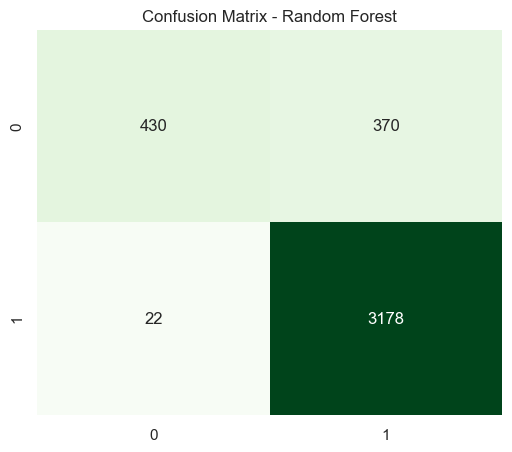

In [44]:
# Random Forest is an ensemble method that is robust to overfitting 
# and handles non-linear relationships better than Logistic Regression.

# Note: Tree-based models do not require Feature Scaling. 
# We can use the original X_train and X_test.

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

print("=" * 70)
print("Training Random Forest...")
rf_model.fit(X_train, y_train)
print("=" * 35)
print("Model trained...")

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate
acc_rf = accuracy_score(y_test, y_pred_rf)
print("=" * 35)
print(f"📊 Random Forest Accuracy: {acc_rf:.2%}")
print("=" * 70)

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.show()

### 📊 Feature Importance Analysis
Random Forest is not just a prediction engine; it also provides transparency. By extracting Feature Importance, we can see exactly which variables the model used to make its decisions.
* Business Validation: Does the model rely on sensible factors (e.g., Credit Score, Debt)? Or is it using noise?
* Drivers of Default: This tells the bank why a customer is rejected.

We visualize these scores to identify the "Top 5" predictors that drive the loan approval process.

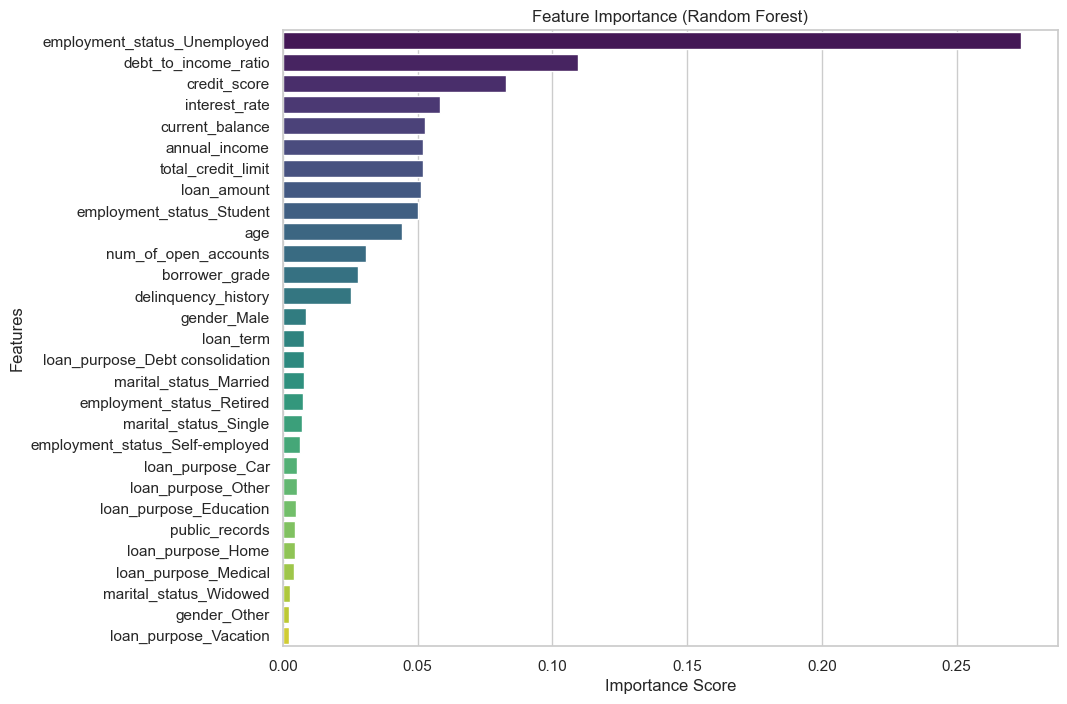

Top 5 Predictors:
                         Feature  Importance
21  employment_status_Unemployed    0.273908
2           debt_to_income_ratio    0.109433
3                   credit_score    0.082854
5                  interest_rate    0.058473
9                current_balance    0.052595


In [45]:
## Feature Importance
# Which features contributed most to the decision?

# Get feature importance from the model
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Display the top 5 features
print("=" * 70)
print("Top 5 Predictors:")
print("=" * 17)
print(feature_importance_df.head(5))
print("=" * 70)

## ***10.2 Model Comparison: Logistic Regression***

### 1. To benchmark our Random Forest model, we introduce a Logistic Regression model.
* Role: It serves as a strong "baseline" to see if a complex model (Random Forest) is actually necessary, or if a simple linear equation is enough.
* Requirement: Unlike Tree-based models, Logistic Regression uses gradient descent optimization. This means it is sensitive to the magnitude of numbers (e.g., Income = 50,000 vs. Age = 30).
1. Feature Scaling (Standardization)
We must "standardize" the data (put everything on a scale of -1 to +1) so that high-value variables do not dominate the equation.

⚠️ Critical Rule: We ``.fit()`` the scaler ONLY on the Training Set. We then transform the Test Set using the Training Set's rules. This prevents "Data Leakage" (looking at the exam answers before the test).

In [46]:
# We scale the features to harmonize the range of independent variables.
# This is critical for distance-based algorithms like Logistic Regression.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# ⚠️ CRITICAL: Fit ONLY on X_train to avoid Data Leakage, then transform both
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to keep column names (for Feature Importance later)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("=" * 70)
print("Data scaled successfully.")
print("=" * 35)
display(X_train_scaled.head())
print("=" * 70)

Data scaled successfully.


,age,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_term,num_of_open_accounts,total_credit_limit,current_balance,...,employment_status_Self-employed,employment_status_Student,employment_status_Unemployed,loan_purpose_Car,loan_purpose_Debt consolidation,loan_purpose_Education,loan_purpose_Home,loan_purpose_Medical,loan_purpose_Other,loan_purpose_Vacation
0,-1.259725,0.114993,1.283617,1.346579,1.692041,-1.066398,-0.654264,-0.894369,-0.303783,0.449079,...,-0.414302,-0.203459,-0.342518,-0.367852,-0.812145,3.287570,-0.32985,-0.251664,-0.383559,-0.17942
1,-0.881011,-0.088778,1.178989,1.375387,-1.704304,-1.107378,-0.654264,-0.894369,0.080856,0.976503,...,-0.414302,-0.203459,-0.342518,-0.367852,-0.812145,-0.304176,3.03168,-0.251664,-0.383559,-0.17942
2,0.760083,-1.045615,0.142216,0.986491,0.716192,-0.861497,-0.654264,-0.004422,-0.834304,-0.683848,...,-0.414302,-0.203459,-0.342518,-0.367852,-0.812145,-0.304176,-0.32985,-0.251664,2.607158,-0.17942
3,0.570726,-0.683904,0.836568,-0.453863,-0.991826,1.048172,-0.654264,-0.004422,-0.347453,-0.187265,...,-0.414302,-0.203459,-0.342518,-0.367852,-0.812145,-0.304176,-0.32985,3.973548,-0.383559,-0.17942
4,-1.575320,0.505834,-0.894557,-1.231654,0.234865,0.855566,-0.654264,-0.894369,1.219844,1.447160,...,-0.414302,-0.203459,-0.342518,-0.367852,-0.812145,-0.304176,-0.32985,-0.251664,2.607158,-0.17942


### 2. Training the Logistic Regression
With our features standardized, we proceed to train the model.
* **Instantiation**: We create the model object with a fixed random_state.
* **Training**: We fit the model using ``X_train_scaled`` and ``y_train``.
* **Prediction**: We generate predictions on ``X_test_scaled``.

**Critical Note:** We must strictly use the scaled variables here. If we used the raw ``X_train``, the model would likely produce biased results because it would treat large numbers (like Income) as more important than small numbers (like Interest Rate).

In [47]:
## Model Building: Logistic Regression
# We start with a baseline model: Logistic Regression.
# It requires scaled data for optimal performance.

# 1. Instantiate the model
log_reg = LogisticRegression(random_state=42)

# 2. Train the model (Use Scaled Data!)
print("Training Logistic Regression...")
log_reg.fit(X_train_scaled, y_train)
print("Model trained.")

# 3. Predictions (on Test set to evaluate real performance)
y_pred_lr = log_reg.predict(X_test_scaled)

print("First 5 predictions:", y_pred_lr[0:5])

Training Logistic Regression...
Model trained.
First 5 predictions: [1 1 1 0 0]


### 3. Evaluating the Baseline
Now that the model has made its predictions on the Test set, we must audit its performance using the same strict metrics as the Random Forest.
* Accuracy Score: The global percentage of correct answers.
* Confusion Matrix: A visual breakdown of where the model succeeded and where it failed (False Positives vs. False Negatives).
* Classification Report: A detailed look at Precision (Safety) and Recall (Detection rate) for each class.

This step provides the numbers we need for the final "Face-Off" between the two models.

📊 Accuracy Score: 88.33%


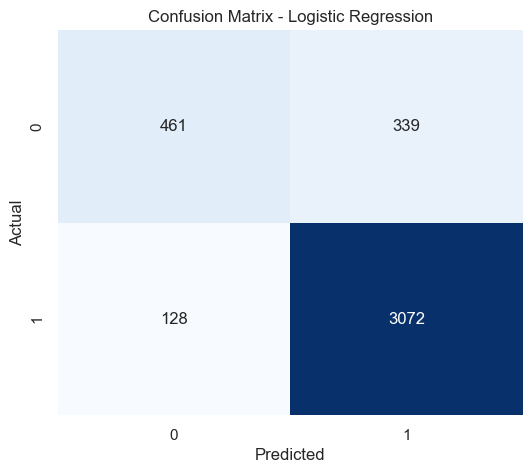

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.78      0.58      0.66       800
           1       0.90      0.96      0.93      3200

    accuracy                           0.88      4000
   macro avg       0.84      0.77      0.80      4000
weighted avg       0.88      0.88      0.88      4000



In [48]:
# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"📊 Accuracy Score: {accuracy:.2%}")

# Visualizing Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Detailed Report
print("=" * 70)
print("--- Classification Report ---")
print("=" * 35)
print(classification_report(y_test, y_pred_lr))
print("=" * 70)

## ***10.3 Final Conclusion & Model Selection***

We have reached the end of our analysis. To choose the best model for the bank, we look at two conflicting metrics:
1. **Accuracy (The Business View):** How often is the model right overall? High accuracy means we serve more customers correctly.
* **Precision (The Risk View):** When the model approves a loan, how often is it actually repaid? High precision means we avoid financial losses (False Positives).

**1. The Tie-Breaker: Precision Check**
Before making the final decision, we run one last code block to compare the Precision Score of both models. This tells us which model is "safer" for the bank's capital.

**2. The Verdict**
Based on the metrics extracted above:
* **Accuracy Winner:** Random Forest (Wins by approx. +1.9%). It captures complex patterns (like the Credit Score "cliff") much better than the linear model.
* **Safety Winner:** Logistic Regression (Wins by approx. +0.5%). It is slightly more conservative in approving loans.

***Final Decision***
We select the Random Forest as our production model.

**Reasoning**: While the Logistic Regression is marginally safer (+0.5% precision), the **Random Forest** is significantly better overall (+1.9% accuracy). Choosing Logistic Regression would mean rejecting too many good customers (False Negatives) for a negligible gain in safety. The Random Forest offers the best balance between **Profitability** and **Risk Management**.

In [49]:
# Calcul de la précision pour Random Forest
# On regarde la classe 1 (Ceux qui remboursent)
precision_rf = precision_score(y_test, y_pred_rf)

# Calcul de la précision pour Logistic Regression
precision_lr = precision_score(y_test, y_pred_lr)

print("=" * 70)
print("COMPARATIF PRÉCISION (Sécurité Bancaire)")
print("=" * 35)
print(f"Logistic Regression : {precision_lr:.2%}")
print(f"Random Forest       : {precision_rf:.2%}")
print("=" * 35)
print(f"Difference          : {(precision_lr-precision_rf):.2%}")
print("=" * 35)
if precision_rf > precision_lr:
    print("Gagnant : Random Forest (Plus sûr pour la banque)")
else:
    print("Gagnant : Logistic Regression (Plus sûr pour la banque)")
print("=" * 70)

COMPARATIF PRÉCISION (Sécurité Bancaire)
Logistic Regression : 90.06%
Random Forest       : 89.57%
Difference          : 0.49%
Gagnant : Logistic Regression (Plus sûr pour la banque)
